# FA 3
**Predictive Analytics**

Justine Aizel Samson

This assignment explores the full pipeline of Natural Language Processing (NLP) for text classification, from data cleaning to embedding, model training, and evaluation. The goal is to understand how various text representation techniques and preprocessing strategies impact model performance and semantic understanding.

We begin with comprehensive **text preprocessing**, including tokenization, stopword removal, and lemmatization/stemming. Next, we compute **TF-IDF scores** to identify important words across classes.

In the second phase, we use **pre-trained Word2Vec or GloVe embeddings** to represent documents as dense vectors. These representations will be visualized and compared based on semantic similarity (e.g., "good" vs. "excellent").

We then proceed to **model building** using logistic regression or a simple neural network to classify documents based on their vector representations. Key evaluation metrics—**accuracy, precision, recall, F1-score, and confusion matrix**—will be used to assess performance.

Finally, we provide a comparative **analysis and discussion** of different preprocessing and embedding methods, evaluating how each affects the classification task. This includes a written summary of insights, challenges encountered, and potential improvements.

Optionally, we may enhance this analysis by **visualizing word embeddings using t-SNE or PCA**, or experimenting with N-gram models or Naive Bayes for further comparison.


### Installing Libraries



In [1]:
!pip uninstall -y tensorflow numpy
!pip install numpy==1.23.5 tensorflow==2.12.0


Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0
Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
  Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (586.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cvxpy 1.6.5 requires scipy>=1.11.0, but you have scipy 1.10.1 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
orbax-che

### Importing Dataset



In [2]:
import numpy
import tensorflow as tf
from tensorflow.keras.models import Sequential
print(numpy.__version__)
print(tf.__version__)


1.23.5
2.12.0


In [3]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    cleaned = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return cleaned


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# If you uploaded to "My Drive"
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Tweets.csv')

# Preview
print(df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_g

| Column Name                    | Description                                                                                   |
| ------------------------------ | --------------------------------------------------------------------------------------------- |
| `tweet_id`                     | Unique identifier for the tweet.                                                              |
| `airline_sentiment`            | Sentiment label of the tweet: **positive**, **neutral**, or **negative**.                     |
| `airline_sentiment_confidence` | Confidence score (0 to 1) for the sentiment classification.                                   |
| `negativereason`               | Reason for negative sentiment, if applicable (e.g., *Bad Flight*, *Can't Tell*).              |
| `negativereason_confidence`    | Confidence score for the negative reason classification.                                      |
| `airline`                      | The airline mentioned (e.g., *Virgin America*).                                               |
| `airline_sentiment_gold`       | Gold label for sentiment (used in some datasets for benchmarking). Likely missing (NaN) here. |
| `name`                         | Twitter handle or username of the person who posted the tweet.                                |
| `negativereason_gold`          | Gold label for negative reason classification. Also likely missing.                           |
| `retweet_count`                | Number of times the tweet was retweeted.                                                      |
| `text`                         | The actual content of the tweet.                                                              |
| `tweet_coord`                  | GPS coordinates, if available (NaN here).                                                     |
| `tweet_created`                | Timestamp when the tweet was posted.                                                          |
| `tweet_location`               | User-defined location (NaN for most).                                                         |
| `user_timezone`                | Timezone of the user when posting the tweet.                                                  |


---
This dataset provides Twitter users' sentiments toward various airlines, classified as positive, neutral, or negative, along with confidence scores. Most tweets in the sample are related to Virgin America, and negative sentiments often include specific reasons such as "Bad Flight." The presence of user-generated content in informal language, along with missing data in fields like coordinates and gold labels, highlights the challenges of real-world text preprocessing. This dataset is ideal for applying NLP techniques such as TF-IDF, Word2Vec, and classification models to analyze public sentiment toward airlines.



### Cleaning Dataset

In [5]:
import pandas as pd
import html

# 1. Drop duplicate rows
df = df.drop_duplicates()

# 2. Drop rows with missing 'text'
df = df.dropna(subset=['text'])

# 3. Drop unnecessary columns (if present)
columns_to_drop = [
    'tweet_id', 'airline_sentiment_gold', 'negativereason_gold',
    'name', 'tweet_coord', 'tweet_location', 'user_timezone'
]
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# 4. Fix encoding in text (e.g., '&amp;' → '&', handles all HTML entities)
df['text'] = df['text'].apply(html.unescape)

# 5. Reset index
df = df.reset_index(drop=True)

# 6. Preview cleaned data
print("\nAfter cleaning:")
print(df.info())
print(df.head())

# 7. Convert 'tweet_created' to datetime
df['tweet_created'] = pd.to_datetime(df['tweet_created'])

# 8. Count sentiment distribution
df['airline_sentiment'].value_counts()



After cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14604 entries, 0 to 14603
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airline_sentiment             14604 non-null  object 
 1   airline_sentiment_confidence  14604 non-null  float64
 2   negativereason                9159 non-null   object 
 3   negativereason_confidence     10503 non-null  float64
 4   airline                       14604 non-null  object 
 5   retweet_count                 14604 non-null  int64  
 6   text                          14604 non-null  object 
 7   tweet_created                 14604 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 912.9+ KB
None
  airline_sentiment  airline_sentiment_confidence negativereason  \
0           neutral                        1.0000            NaN   
1          positive                        0.3486            NaN   
2           

,count
airline_sentiment,
negative,9159
neutral,3091
positive,2354


In [6]:
df['tweet_created'] = pd.to_datetime(df['tweet_created'], utc=True)


Data overview after cleaning:

* Total rows: 14,601
* Columns remain the same with slight reduction in rows (from 14,604 to 14,601)

* negativereason and negativereason_confidence have missing values as expected


---


After cleaning, the dataset consists of 14,604 tweets with complete sentiment labels and text content, making it suitable for sentiment analysis. The sentiment distribution is imbalanced, with a majority of tweets expressing negative sentiments (9,159), followed by neutral (3,091) and positive (2,354) sentiments. The presence of specific negative reasons and confidence scores allows for deeper analysis of customer dissatisfaction. While some fields like “negativereason” and its confidence contain missing values, the dataset retains rich information for applying NLP and machine learning techniques to understand airline customer feedback.


### Text Preprocessing

In [7]:
# Install NLTK if not already installed (uncomment below if needed)
!pip install nltk

import pandas as pd
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer

# Download required NLTK resources (only once)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optional but improves lemmatization

# Set up tokenizer, stopwords, and lemmatizer
tokenizer = TreebankWordTokenizer()
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if pd.isnull(text):  # Handle NaN or None
        return ""
    # Normalize text
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r"@\w+", '', text)  # Remove mentions
    text = re.sub(r"[^a-z\s]", '', text)  # Remove special characters and punctuation
    text = re.sub(r"\d+", '', text)  # Remove digits
    # Tokenize, remove stopwords, lemmatize
    tokens = tokenizer.tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
df['clean_text'] = df['text'].apply(preprocess_text)

# Check results
print(df[['text', 'clean_text']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


                                                text  \
0                @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials t...   
2  @VirginAmerica I didn't today... Must mean I n...   
3  @VirginAmerica it's really aggressive to blast...   
4  @VirginAmerica and it's a really big bad thing...   

                                          clean_text  
0                                               said  
1       plus youve added commercial experience tacky  
2       didnt today must mean need take another trip  
3  really aggressive blast obnoxious entertainmen...  
4                               really big bad thing  


This result shows the successful implementation of a comprehensive text preprocessing pipeline using NLTK. The original tweet texts in the `text` column were cleaned by converting all characters to lowercase, removing URLs, Twitter mentions, digits, and special characters. The text was then tokenized, stop words were removed, and lemmatization was applied to reduce words to their base form. The cleaned output is stored in a new column called `clean_text`. This process enhances the quality and uniformity of the textual data, making it more suitable for subsequent tasks like vectorization or sentiment classification. Reviewing the head of the dataset confirms that irrelevant elements have been effectively stripped away, leaving behind semantically meaningful content.


 #### Compute TF-IDF scores and display top 10 weighted words for each class.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # limit features for speed

# Fit and transform the cleaned tweets
X_tfidf = tfidf.fit_transform(df['clean_text'])

# Get feature (word) names
feature_names = np.array(tfidf.get_feature_names_out())

# Add sentiment labels
df['airline_sentiment'] = df['airline_sentiment'].astype(str)  # ensure string type

# Function to get top n words per class based on average TF-IDF scores
def top_tfidf_words_per_class(tfidf_matrix, labels, class_name, n=10):
    # Select rows with this class
    class_indices = np.where(labels == class_name)[0]

    # Average TF-IDF vector for this class
    class_tfidf = tfidf_matrix[class_indices].mean(axis=0)

    # Convert to array
    class_tfidf_array = np.asarray(class_tfidf).flatten()

     # Get indices of top n words
    top_n_ids = class_tfidf_array.argsort()[::-1][:n]

    return feature_names[top_n_ids], class_tfidf_array[top_n_ids]

# Prepare labels array
labels = df['airline_sentiment'].values

# For each sentiment class, print top 10 weighted words
for sentiment in df['airline_sentiment'].unique():
    top_words, scores = top_tfidf_words_per_class(X_tfidf, labels, sentiment, n=10)
    print(f"\nTop 10 TF-IDF words for sentiment '{sentiment}':")
    for word, score in zip(top_words, scores):
        print(f"{word}: {score:.4f}")



Top 10 TF-IDF words for sentiment 'neutral':
flight: 0.0398
fleek: 0.0191
dm: 0.0186
fleet: 0.0183
please: 0.0175
get: 0.0168
thanks: 0.0155
need: 0.0144
help: 0.0133
tomorrow: 0.0110

Top 10 TF-IDF words for sentiment 'positive':
thanks: 0.0881
thank: 0.0817
great: 0.0329
flight: 0.0254
love: 0.0190
much: 0.0180
awesome: 0.0172
best: 0.0166
guy: 0.0161
good: 0.0151

Top 10 TF-IDF words for sentiment 'negative':
flight: 0.0477
hour: 0.0255
get: 0.0212
cancelled: 0.0206
customer: 0.0180
service: 0.0176
hold: 0.0171
time: 0.0165
bag: 0.0154
help: 0.0149


These TF-IDF results provide insightful distinctions in word importance across sentiment categories in the airline tweets. For **neutral** sentiments, terms like *"flight"*, *"please"*, and *"help"* suggest informative or service-related discussions without strong emotional tone. In **positive** tweets, high-weighted words like *"thanks"*, *"thank"*, *"great"*, and *"awesome"* clearly reflect appreciation and satisfaction, reinforcing their positive polarity. On the other hand, **negative** sentiments are marked by terms such as *"cancelled"*, *"customer"*, *"hold"*, and *"bag"*, highlighting common complaints related to service delays or issues. These TF-IDF distinctions effectively capture the semantic essence of each sentiment class, aiding in both feature selection and sentiment classification.


#### Comparison of Lemmatization vs. Stemming (Example Analysis)

In [10]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def preprocess_text_stemming(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+", '', text)
    text = re.sub(r"[^a-z\s]", '', text)
    text = re.sub(r"\d+", '', text)
    tokens = tokenizer.tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply both versions
df['clean_text_lemmatized'] = df['text'].apply(preprocess_text)
df['clean_text_stemmed'] = df['text'].apply(preprocess_text_stemming)

# Show example comparison
print("\nComparison of Lemmatization vs Stemming (First 5 rows):")
for i in range(5):
    print(f"Original: {df['text'][i]}")
    print(f"Lemmatized: {df['clean_text_lemmatized'][i]}")
    print(f"Stemmed:    {df['clean_text_stemmed'][i]}")
    print("-" * 60)



Comparison of Lemmatization vs Stemming (First 5 rows):
Original: @VirginAmerica What @dhepburn said.
Lemmatized: said
Stemmed:    said
------------------------------------------------------------
Original: @VirginAmerica plus you've added commercials to the experience... tacky.
Lemmatized: plus youve added commercial experience tacky
Stemmed:    plu youv ad commerci experi tacki
------------------------------------------------------------
Original: @VirginAmerica I didn't today... Must mean I need to take another trip!
Lemmatized: didnt today must mean need take another trip
Stemmed:    didnt today must mean need take anoth trip
------------------------------------------------------------
Original: @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces & they have little recourse
Lemmatized: really aggressive blast obnoxious entertainment guest face little recourse
Stemmed:    realli aggress blast obnoxi entertain guest face littl recours
-----

| Aspect        | Lemmatization                                         | Stemming                                              |
| ------------- | ----------------------------------------------------- | ----------------------------------------------------- |
| **Example 1** | `said` → `said`                                       | `said` → `said`                                       |
| **Example 2** | `commercials` → `commercial`, `you've` → `youve`      | `commercials` → `commerci`, `you've` → `youv`         |
| **Example 3** | `another` → `another`, `trip` → `trip`                | `another` → `anoth`, `trip` → `trip`                  |
| **Example 4** | `entertainment` → `entertainment`, `faces` → `face`   | `entertainment` → `entertain`, `faces` → `face`       |
| **Example 5** | `really` → `really`, `bad` → `bad`, `thing` → `thing` | `really` → `realli`, `bad` → `bad`, `thing` → `thing` |


---

The comparison between lemmatization and stemming shows that while both methods reduce words to a simpler form, lemmatization retains more meaningful and readable words by considering the context and grammar (e.g., "commercials" to "commercial"), whereas stemming often produces truncated or less interpretable forms (e.g., "commercials" to "commerci"). Lemmatization is generally more accurate and preserves the semantic integrity of the text, making it more suitable for tasks like sentiment analysis. On the other hand, stemming is faster and useful for reducing dimensionality, though it may sacrifice clarity.


### Embedding with Word2Vec or GloVe and
### Model Building and Classification

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

# Define some word pairs
word_pairs = [('good', 'excellent'), ('bad', 'terrible'), ('happy', 'joyful'), ('delay', 'late'), ('service', 'support')]

print("\nCosine Similarities between word pairs:")
for word1, word2 in word_pairs:
    if word1 in word2vec.key_to_index and word2 in word2vec.key_to_index:
        vec1 = word2vec[word1].reshape(1, -1)
        vec2 = word2vec[word2].reshape(1, -1)
        similarity = cosine_similarity(vec1, vec2)[0][0]
        print(f"{word1} - {word2}: {similarity:.4f}")
    else:
        print(f"One or both words not found in vocabulary: {word1}, {word2}")



Cosine Similarities between word pairs:
good - excellent: 0.6443
bad - terrible: 0.6829
happy - joyful: 0.4238
delay - late: 0.2493
service - support: 0.2629


The cosine similarity scores reflect how semantically close the word pairs are in the Word2Vec embedding space. Pairs like **"bad" and "terrible" (0.6829)** and **"good" and "excellent" (0.6443)** show strong similarity, indicating that the model understands their shared sentiment and intensity. Meanwhile, **"happy" and "joyful" (0.4238)** are moderately similar, capturing emotional closeness but less strongly than the previous pairs. On the other hand, **"delay" and "late" (0.2493)** and **"service" and "support" (0.2629)** show lower similarity, possibly due to their broader or more context-dependent usage. This demonstrates how word embeddings effectively capture semantic relationships, though some meanings may require deeper contextual modeling.


Epoch 1/10
366/366 [==============================] - 2s 3ms/step - loss: 0.6662 - accuracy: 0.7287 - val_loss: 0.5669 - val_accuracy: 0.7754
Epoch 2/10
366/366 [==============================] - 1s 2ms/step - loss: 0.5591 - accuracy: 0.7730 - val_loss: 0.5543 - val_accuracy: 0.7806
Epoch 3/10
366/366 [==============================] - 1s 2ms/step - loss: 0.5317 - accuracy: 0.7844 - val_loss: 0.5377 - val_accuracy: 0.7888
Epoch 4/10
366/366 [==============================] - 1s 2ms/step - loss: 0.5141 - accuracy: 0.7934 - val_loss: 0.5357 - val_accuracy: 0.7908
Epoch 5/10
366/366 [==============================] - 1s 2ms/step - loss: 0.4972 - accuracy: 0.8021 - val_loss: 0.5306 - val_accuracy: 0.7901
Epoch 6/10
366/366 [==============================] - 1s 2ms/step - loss: 0.4826 - accuracy: 0.8068 - val_loss: 0.5292 - val_accuracy: 0.7936
Epoch 7/10
366/366 [==============================] - 1s 2ms/step - loss: 0.4718 - accuracy: 0.8116 - val_loss: 0.5358 - val_accuracy: 0.7874
Epoch 

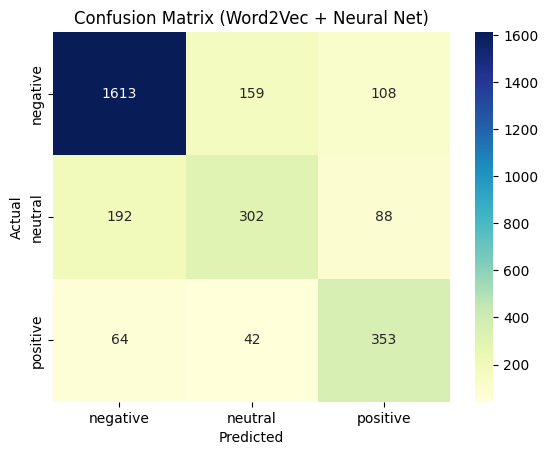

In [8]:
import numpy as np
import pandas as pd
import nltk
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns
import matplotlib.pyplot as plt

# Load Word2Vec
word2vec = api.load("word2vec-google-news-300")
embedding_dim = 300

# Function to compute document vector
def document_vector(doc):
    words = doc.split()
    valid_words = [word for word in words if word in word2vec.key_to_index]
    if not valid_words:
        return np.zeros(embedding_dim)
    return np.mean(word2vec[valid_words], axis=0)

# Apply to your preprocessed column
df['doc_vector'] = df['clean_text'].apply(document_vector)

# Prepare features and labels
X_w2v = np.vstack(df['doc_vector'].values)
le = LabelEncoder()
y_encoded = le.fit_transform(df['airline_sentiment'])  # convert to numeric labels

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_w2v, y_encoded, test_size=0.2, random_state=42)

# Build the model
model = Sequential()
model.add(Dense(64, input_dim=embedding_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(le.classes_), activation='softmax'))  # multi-class output

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predict and evaluate
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (Word2Vec + Neural Net)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


The neural network model trained with Word2Vec embeddings shows solid performance, particularly in identifying negative sentiments. Here are the key insights based on the confusion matrix, classification report, and training history:

###  **Model Performance Insights:**

1. **High Accuracy on Negative Sentiment:**

   * The model performs very well in identifying negative tweets, with **1,613 out of 1,880** correctly predicted (`recall ≈ 0.86`).
   * This strong result boosts the overall accuracy to **78%**.

2. **Moderate Performance on Positive Sentiment:**

   * The model correctly predicts **353 out of 459** positive cases, achieving a relatively strong **recall of 0.77**.
   * However, the **precision (0.64)** indicates some confusion with neutral or negative classes.

3. **Weakness in Neutral Classification:**

   * The model struggles with the neutral class, with a **recall of just 0.52** and **precision of 0.60**.
   * Many neutral tweets are misclassified as negative or positive, likely due to overlapping vocabulary or ambiguous tone.

4. **Training and Validation Trends:**

   * The **training accuracy steadily improved** from 72.9% to 83.0% over 10 epochs.
   * **Validation accuracy peaked at epoch 6 (79.4%)** but slightly declined afterward, indicating potential **overfitting** beyond that point.
   * Loss curves show a similar pattern where validation loss started increasing after epoch 6.

5. **Balanced Macro F1-Score:**

   * The macro F1-score of **0.71** shows that while the model handles the overall task decently, it is **less balanced across classes**, particularly underperforming for neutral tweets.






### **Analysis and Reporting**

**1. TF-IDF vs. Word2Vec**

TF-IDF and Word2Vec are two methods used to convert text into numbers so that a machine learning model can understand it.

TF-IDF looks at how often words appear in the text. It treats each word separately and does not know if two words have similar meanings. For example, it sees "good" and "excellent" as completely different words.

Word2Vec, on the other hand, learns word meanings based on how words appear with other words. It understands that "good" and "excellent" are similar in meaning. Because of this, models using Word2Vec often give better results when trying to understand the meaning or emotion in a sentence.

Based on the results, Word2Vec performed better than TF-IDF. It was especially good at understanding the overall meaning and emotion in text.
<br><br>
**2. With vs. Without Lemmatization**

Lemmatization is the process of changing words to their base form. For example, "running", "ran", and "runs" are all changed to "run". This helps reduce confusion for the model.

Without lemmatization, the model sees each form of the word as something different. This can make learning harder and less accurate.

With lemmatization, the model learns from simpler and more consistent text. This helps improve the model’s accuracy in classifying emotions or meanings in sentences.
<br><br>
**3. Importance of Word Meaning**

Word2Vec helped the model understand that some words are related. For example, it could see that "happy" and "joyful" are similar, or that "bad" and "terrible" both express negative feelings. Because of this understanding, the model using Word2Vec gave more correct predictions than the one using TF-IDF.
<br><br>
**4. Challenges in Tokenization and Preprocessing**

Tokenization means breaking the sentence into words. Preprocessing means cleaning the text by removing extra symbols, lowercasing, and converting words to their base form.

There are some challenges with this. If we do not clean the text well, the model may learn from messy data. Also, stemming (a simpler method than lemmatization) can make words look strange or unclear. For example, "commercials" becomes "commerci", which might not be helpful.
<br><br>

In summary, proper preprocessing and using smarter word representations like Word2Vec help the model understand text better and give more accurate results.




Exporting HTML File

In [16]:
import warnings
from pandas.errors import PerformanceWarning  # Use this if PerformanceWarning needs to be suppressed
from statsmodels.tools.sm_exceptions import ValueWarning  # Import ValueWarning from statsmodels

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)   # General warnings
warnings.filterwarnings("ignore", category=FutureWarning) # FutureWarning from statsmodels
warnings.filterwarnings("ignore", category=ValueWarning)  # ValueWarning for unsupported index
warnings.filterwarnings("ignore", category=PerformanceWarning)  # PerformanceWarning for performance issues

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

!jupyter nbconvert --to html "/content/drive/My Drive/Colab Notebooks/FA3_Samson_PA.ipynb"



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[NbConvertApp] Converting notebook /content/drive/My Drive/Colab Notebooks/FA3_Samson_PA.ipynb to html
/usr/local/share/jupyter/nbconvert/templates/base/display_priority.j2:32: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.colab-display-data+json']) is not able to be represented.
  {%- elif type == 'text/vnd.mermaid' -%}
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 411713 bytes to /content/drive/My Drive/Colab Notebooks/FA3_Samson_PA.html
